In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import openpyxl

# Duplicates

## loading data

In [50]:
data = pd.read_excel("matlab_XLR.xlsx", sheet_name="Results Summary")
data.head()


,Analyte,Lowest\nDetection Limit,Units,White Sturgeon (WS #1) MT,White Sturgeon (WS #2) MT,White Sturgeon (WS #3) MT,White Sturgeon (WS #4) MT,White Sturgeon (WS #5) MT,White Sturgeon (WS #7) MT,White Sturgeon (WS #10) MT,White Sturgeon (WS #11) MT,White Sturgeon (WS #13) MT,White Sturgeon (WS #1) Liver,White Sturgeon (WS #2) Liver,White Sturgeon (WS #4) Liver,White Sturgeon (WS #5) Liver,White Sturgeon (WS #7) Liver,White Sturgeon (WS #10) Liver,White Sturgeon (WS #11) Liver,White Sturgeon (WS #13) Liver
0,Moisture,0.500,%,73.0,70.7,66.0,72.8,74.9,72.9,77.5,72.7,77.7,58.2,50.1,69.8,62.5,57.2,55.6,63.3,75.4
1,Aluminum,2.000,mg/kg,10.0,18.0,<2.0,37.0,<2.0,2.8,2.4,2.5,4.4,7.2,3.7,9.7,3.8,9.4,9.8,7.9,26.4
2,Aluminum,0.400,mg/kg wwt,2.71,5.28,0.42,10.1,0.49,0.77,0.54,0.69,0.98,3.03,1.86,2.94,1.42,4.03,4.33,2.89,6.52
3,Antimony,0.010,mg/kg,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,0.010,0.023
4,Antimony,0.002,mg/kg wwt,<0.0020,0.0022,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,0.0021,0.0029,0.0024,<0.0020,0.0037,0.0057


## loading duplicates

In [51]:
dups = pd.read_excel("matlab_XLR.xlsx", sheet_name="Duplicates")
dups.head()

,ALS ID,Reference,Client Sample ID,QC Type,QC Lot,Analyte,Matrix,Method,Sample Result,Duplicate Result,Detection Limit,Units,RPD(%)\nor Diff.,Duplicate Limits,Qual,Eval
0,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Aluminum,Biota,E440,10.0,7.8,2.00,mg/kg,2.2,Diff <2x LOR,NaN,ü
1,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Antimony,Biota,E440,<0.010,<0.010,0.01,mg/kg,0,Diff <2x LOR,NaN,ü
2,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Arsenic,Biota,E440,0.806,0.869,0.02,mg/kg,7.51%,40,NaN,ü
3,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Barium,Biota,E440,2.47,2.94,0.05,mg/kg,17.4%,40,NaN,ü
4,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Beryllium,Biota,E440,<0.010,<0.010,0.01,mg/kg,0,Diff <2x LOR,NaN,ü


In [52]:
dups['Sample Result'] = dups['Sample Result'].str.removeprefix('<')
dups['Duplicate Result'] = dups['Duplicate Result'].str.removeprefix('<')
dups.head()

,ALS ID,Reference,Client Sample ID,QC Type,QC Lot,Analyte,Matrix,Method,Sample Result,Duplicate Result,Detection Limit,Units,RPD(%)\nor Diff.,Duplicate Limits,Qual,Eval
0,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Aluminum,Biota,E440,10.0,7.8,2.00,mg/kg,2.2,Diff <2x LOR,NaN,ü
1,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Antimony,Biota,E440,0.010,0.010,0.01,mg/kg,0,Diff <2x LOR,NaN,ü
2,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Arsenic,Biota,E440,0.806,0.869,0.02,mg/kg,7.51%,40,NaN,ü
3,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Barium,Biota,E440,2.47,2.94,0.05,mg/kg,17.4%,40,NaN,ü
4,QC-MRG4-966302005,VA23B0556-001,White Sturgeon (WS #1) MT,DUP,966302,Beryllium,Biota,E440,0.010,0.010,0.01,mg/kg,0,Diff <2x LOR,NaN,ü


calculating range, mean, error

In [53]:
range = np.abs(dups['Sample Result'].to_numpy('float') - dups['Duplicate Result'].to_numpy('float'))
mean = np.mean(np.c_[dups['Sample Result'].to_numpy('float'), dups['Duplicate Result'].to_numpy('float')], axis=1)
error = range / mean * 100

creating new tables

In [54]:
nt = pd.DataFrame({'range': range, 'mean': mean, 'error (%)': error})

In [55]:
dups = pd.concat([dups, nt], axis=1)

# liver - muscle plot

In [56]:
data.head()

,Analyte,Lowest\nDetection Limit,Units,White Sturgeon (WS #1) MT,White Sturgeon (WS #2) MT,White Sturgeon (WS #3) MT,White Sturgeon (WS #4) MT,White Sturgeon (WS #5) MT,White Sturgeon (WS #7) MT,White Sturgeon (WS #10) MT,White Sturgeon (WS #11) MT,White Sturgeon (WS #13) MT,White Sturgeon (WS #1) Liver,White Sturgeon (WS #2) Liver,White Sturgeon (WS #4) Liver,White Sturgeon (WS #5) Liver,White Sturgeon (WS #7) Liver,White Sturgeon (WS #10) Liver,White Sturgeon (WS #11) Liver,White Sturgeon (WS #13) Liver
0,Moisture,0.500,%,73.0,70.7,66.0,72.8,74.9,72.9,77.5,72.7,77.7,58.2,50.1,69.8,62.5,57.2,55.6,63.3,75.4
1,Aluminum,2.000,mg/kg,10.0,18.0,<2.0,37.0,<2.0,2.8,2.4,2.5,4.4,7.2,3.7,9.7,3.8,9.4,9.8,7.9,26.4
2,Aluminum,0.400,mg/kg wwt,2.71,5.28,0.42,10.1,0.49,0.77,0.54,0.69,0.98,3.03,1.86,2.94,1.42,4.03,4.33,2.89,6.52
3,Antimony,0.010,mg/kg,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,<0.010,0.010,0.023
4,Antimony,0.002,mg/kg wwt,<0.0020,0.0022,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,<0.0020,0.0021,0.0029,0.0024,<0.0020,0.0037,0.0057


In [57]:
vn = data.columns
for i in np.arange(3, len(vn)):
    temp = data[vn[i]].str.removeprefix("<")
    data[vn[i]] = temp


In [58]:
data.head()

,Analyte,Lowest\nDetection Limit,Units,White Sturgeon (WS #1) MT,White Sturgeon (WS #2) MT,White Sturgeon (WS #3) MT,White Sturgeon (WS #4) MT,White Sturgeon (WS #5) MT,White Sturgeon (WS #7) MT,White Sturgeon (WS #10) MT,White Sturgeon (WS #11) MT,White Sturgeon (WS #13) MT,White Sturgeon (WS #1) Liver,White Sturgeon (WS #2) Liver,White Sturgeon (WS #4) Liver,White Sturgeon (WS #5) Liver,White Sturgeon (WS #7) Liver,White Sturgeon (WS #10) Liver,White Sturgeon (WS #11) Liver,White Sturgeon (WS #13) Liver
0,Moisture,0.500,%,73.0,70.7,66.0,72.8,74.9,72.9,77.5,72.7,77.7,58.2,50.1,69.8,62.5,57.2,55.6,63.3,75.4
1,Aluminum,2.000,mg/kg,10.0,18.0,2.0,37.0,2.0,2.8,2.4,2.5,4.4,7.2,3.7,9.7,3.8,9.4,9.8,7.9,26.4
2,Aluminum,0.400,mg/kg wwt,2.71,5.28,0.42,10.1,0.49,0.77,0.54,0.69,0.98,3.03,1.86,2.94,1.42,4.03,4.33,2.89,6.52
3,Antimony,0.010,mg/kg,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.023
4,Antimony,0.002,mg/kg wwt,0.0020,0.0022,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0020,0.0021,0.0029,0.0024,0.0020,0.0037,0.0057


# Ploting mentioned elements

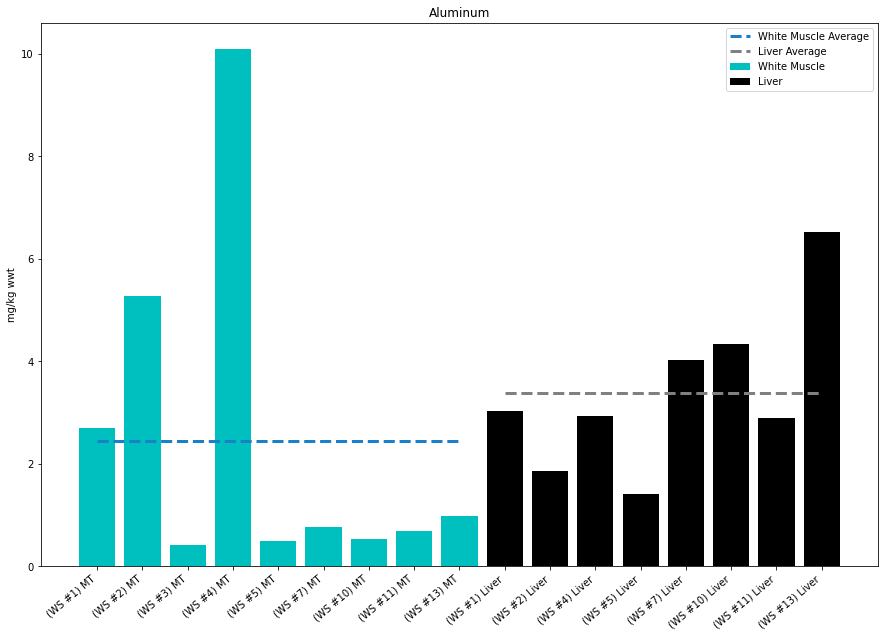

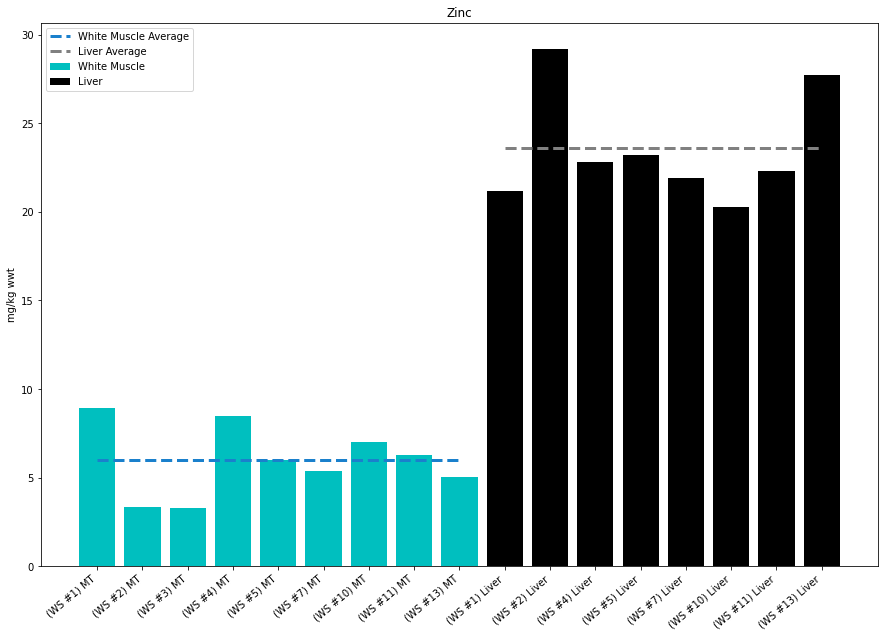

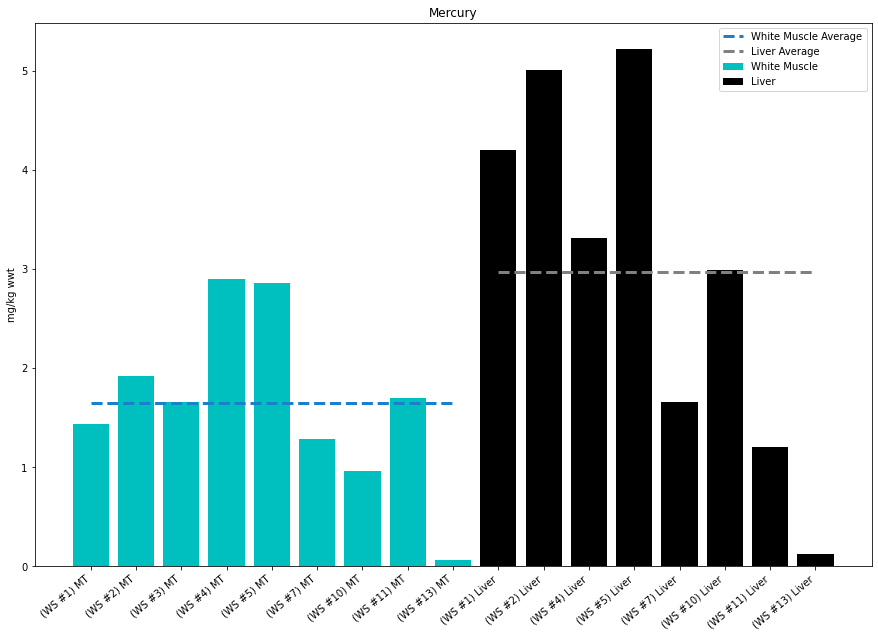

In [59]:
elements = ["Aluminum", "Zinc", "Mercury"]
## to plot all elements uncomment bellow
# elements = data["Analyte"][1::2].to_list()

# to save the picture of an element figure, set the corrosponding value to True
# save_pic = [False, False, True]

## to save all uncomment below
save_pic = np.ones(len(elements), dtype="bool")


x = data.columns[3:]
# seperating liver and mt using columns contatins the word "Li`ver"
Liver_id = x.str.contains("Liver")

for i in np.arange(len(elements)):
    # creating figure
    fig, ax = plt.subplots(figsize=(15, 10))
    fig.set_facecolor("White")
    # obtaining related data
    values = np.array(data[np.logical_and(data["Analyte"] == elements[i], data["Units"] == "mg/kg wwt")].to_numpy()[:, 3:].ravel(), dtype=float)
    # bar ploting mt
    ax.bar(x[~Liver_id], values[~Liver_id], color = "c", label="White Muscle")
    # bar ploting liver
    ax.bar(x[Liver_id], values[Liver_id], color = "k", label="Liver")
    # ploting mean of mt
    ax.plot(x[~Liver_id], np.mean(values[~Liver_id]) * np.ones(x[~Liver_id].shape), color = [0.1, 0.5, 0.8], label = "White Muscle Average", linestyle = "dashed", linewidth = 3)
    # ploting mean of liver
    ax.plot(x[Liver_id], np.mean(values[Liver_id]) * np.ones(x[Liver_id].shape), color = "gray", label = "Liver Average", linestyle = "dashed", linewidth = 3)
    # setting axis side names
    ax.set_xlabel("")
    ax.set_ylabel("mg/kg wwt")
    ax.set_title(elements[i])
    # setting xticks and xtick labels
    ax.xaxis.set_ticks(np.arange(data.shape[1]-3))
    ax.xaxis.set_ticklabels(data.columns[3:].str.removeprefix("White Sturgeon "), rotation = 40, ha = "right")
    # enabling legend
    ax.legend()
    if not os.path.exists("./pics/"):
        os.makedirs("./pics/")
    if save_pic[i] == True:
        fig.savefig("./pics/"+elements[i]+".png")

# Statistics

In [60]:
from scipy.stats import shapiro

## Shapiro test

In [61]:
shapiro_dict = {}
# elements = ["Aluminum", "Zinc", "Mercury"]
elements = data["Analyte"][1::2].to_list()
for element in elements:
    result_liver = shapiro(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt")].iloc[:, 3:].to_numpy("double")[:, Liver_id])
    result_mt = shapiro(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt")].iloc[:, 3:].to_numpy("double")[:, ~Liver_id])
    shapiro_dict.update({element: [*result_liver, *result_mt]})

/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [62]:
shapiro_table = pd.DataFrame(np.c_[np.array(list(shapiro_dict.keys()), dtype="str"), np.array(list(shapiro_dict.values()))], columns=["analyte", "liver statistic", "liver p-value", "mt statistics", "mt p-value"])

## pearson correlation factor

In [63]:
## extracting matching columns
liver_temp = x[Liver_id].str.removesuffix(" Liver")
mt_temp = x[~Liver_id].str.removesuffix(" MT")
test_columns = []
for cl in liver_temp:
    if cl in mt_temp:
        test_columns.append(cl)

liver_columns = [x+" Liver" for x in test_columns]
mt_columns = [x+" MT" for x in test_columns]

In [64]:
from scipy.stats import pearsonr

In [65]:
pearson_dict = {}
# elements = ["Aluminum", "Zinc", "Mercury"]
elements = data["Analyte"][1::2].to_list()
for element in elements:
    result = pearsonr(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"), liver_columns].to_numpy("double").ravel(), data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"), mt_columns].to_numpy("double").ravel())
    pearson_dict.update({element: [*result]})

/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: Con

In [66]:
pearson_dict
pearson_liver_mt_table = pd.DataFrame(np.c_[np.array(list(pearson_dict.keys()), dtype="str")[:, np.newaxis], data.loc[data["Units"] == "mg/kg wwt", [*liver_columns, *mt_columns]].to_numpy("single"), np.array(list(pearson_dict.values()))], columns=["analyte", *[*liver_columns, *mt_columns], "statistic", "p-value"])

### pearson element by element correlation check

In [124]:
corr_matrix = np.corrcoef(data.loc[data["Units"] == "mg/kg wwt", x].to_numpy("single").T, rowvar=False).round(decimals = 2)
id = ~np.isnan(corr_matrix)[0, :]
elements = data["Analyte"][1::2].to_numpy("str")[id]
corr_matrix = corr_matrix[id, :]
corr_matrix = corr_matrix[:, id]

/Users/amir/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


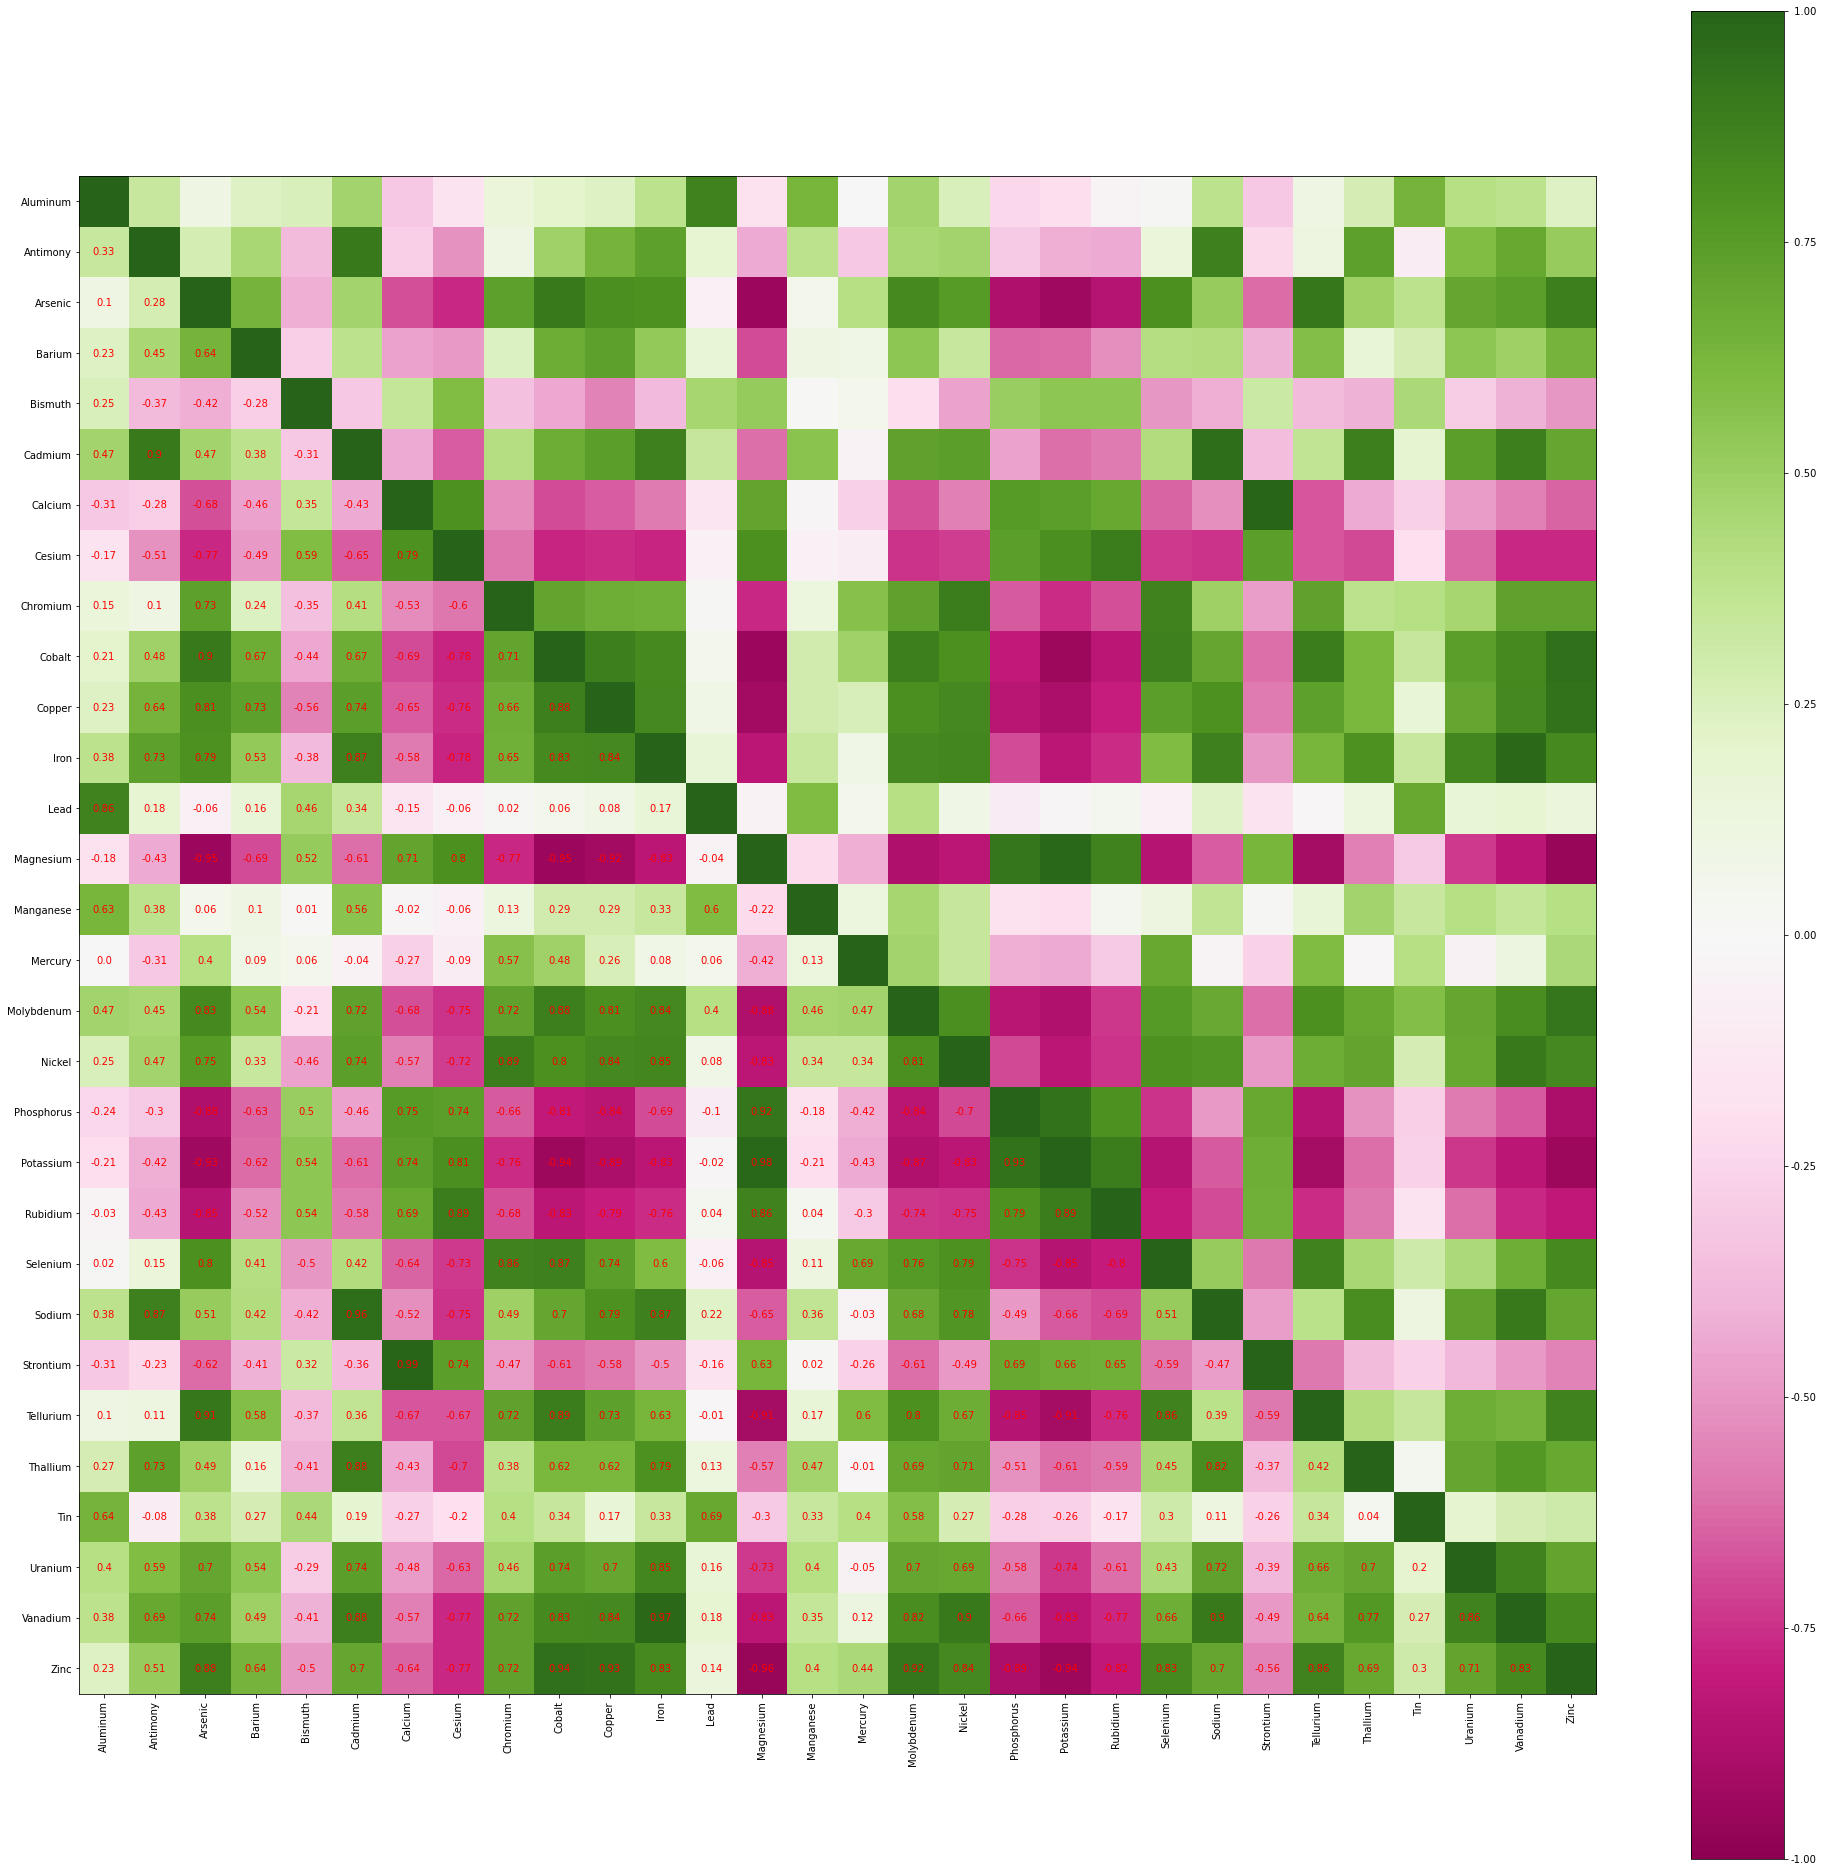

In [127]:
fig, ax = plt.subplots(figsize = (34, 34))
cmap = plt.cm.PiYG
im = ax.imshow(corr_matrix, cmap=cmap)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set_ticks(np.arange(len(elements)), elements, rotation = 90)
ax.yaxis.set_ticks(np.arange(len(elements)), elements)
# ax.set_ylim(2.5, -0.5)
for i in np.arange(len(elements)):
    for j in np.arange(i):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.savefig("./pics/pearson.png")
plt.show()


## making excel for statistics
 dups, shapiro, pearson -> stats.xlsx

In [70]:
with pd.ExcelWriter('stats.xlsx') as writer:
    dups.to_excel(writer, sheet_name="dups")
    shapiro_table.to_excel(writer, sheet_name="shapiro")
    pearson_liver_mt_table.to_excel(writer, sheet_name="pearson liver-mt")

34